In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import subplot,imshow,title,gray,NullLocator
import scipy.misc as mi
import scipy.special as sp
from PIL import Image
from itertools import chain
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.models import model_from_json

from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# visualizza dati
def displayData(X, t, rows=10, cols=10, img_ind=None, size =16, class_value = False):
    if len(X)>rows*cols:
        img_ind = np.random.permutation(len(X))[0:rows * cols]
    else:
        img_ind = range(rows*cols)
    fig = plt.figure(figsize = (size,size))
    fig.patch.set_facecolor('white')
    ax = fig.gca()
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow([255-x for x in X[img_ind[i]]], cmap='gray', interpolation='gaussian')
        if class_value:
            plt.title("{}".format(t[img_ind[i]]),fontsize = 16, color='b')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.axis('off')
    plt.subplots_adjust(top=1)
    plt.show()

In [0]:
def plotData(X, Y, c, npixel=28):
    m, n = X.shape
    image = np.array(X[c,:])
    plt.figure(figsize = (6,6))
    plt.imshow((image.reshape(npixel, npixel)), cmap='Greys', interpolation='quadric')
    plt.show()

In [0]:
def plotAccuracy(acc_history_train, acc_history_test):
    plt.figure(figsize = (12,8))
    plt.plot(acc_history_train, marker='o', markersize=5, label='Train')
    plt.plot(acc_history_test, marker='o', markersize=5, label='Test')
    plt.legend()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.show()

In [0]:
def save_model(m,filename):
    model_json = m.to_json()
    with open("/gdrive/My Drive/colab_data/"+filename+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    m.save_weights("/gdrive/My Drive/colab_data/"+filename+".h5")
    print("Saved model to disk")

In [0]:
def load_model_weights(filename, model):
    model.load_weights("/gdrive/My Drive/colab_data/"+filename+".h5")
    print("Loaded weights from disk")
    return model

In [0]:
def load_model(filename):
    json_file = open("/gdrive/My Drive/colab_data/"+filename+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    m = model_from_json(loaded_model_json)
    # load weights into new model
    m.load_weights("/gdrive/My Drive/colab_data/"+filename+".h5")
    print("Loaded model from disk")
    return m

Fissa il numero di classi pari a 10 (corrispondenti alle cifre 0,1,...,9) e leggi i dati, suddivisi in training e test set, $(X_{train}, t_{train}), (X_{test}, t_{test})$. Le matrici $X$ rappresentano le immagini, mentre i vettori $t$ specificano le relative classi.

In [0]:
nb_classes = 10

(X_train, t_train), (X_test, t_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

Visualizza la dimensione di $X_{train}$ e $X_{test}$. Le immagini rappresentate risultano indicizzate dalla prima dimensione e definite come matrici $28\times 28$. I valori nelle matrici sono interi compresi tra $0$ e $255$.


In [0]:
X_train[0,:,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Esempio: i primi 100 elementi nel training set con la relativa classe

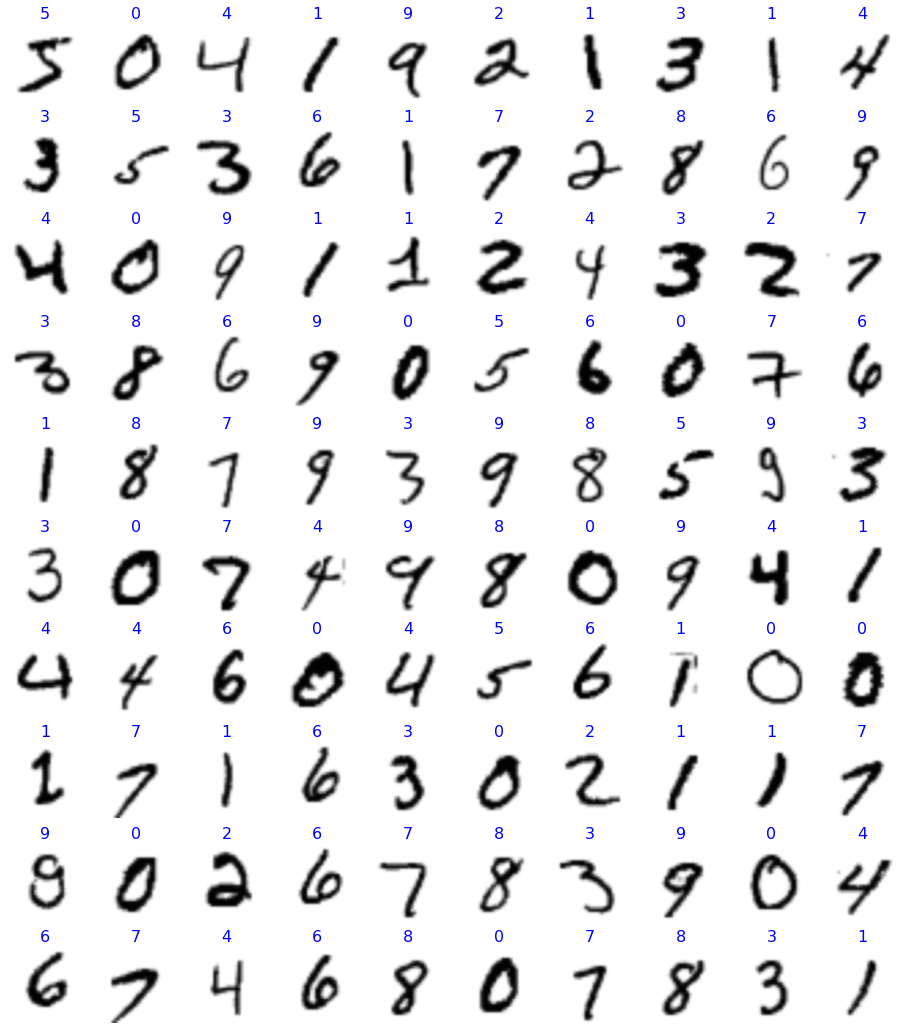

In [0]:
displayData(X_train[0:100], t_train[0:100], class_value=True)

Modifica la rappresentazione degli elementi da matrici $28\times 28$ a vettori di dimensione $784$, con elementi reali compresi tra $0$ e $1$.

In [0]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [0]:
X_train[0,:].shape

(784,)

Le classi vengono codificate nella forma $\textit{one-hot}$, come vettori di dimensione $10$ (il numero delle classi) con elementi pari a $0$, eccetto quello di indice pari al valore da codificare.


In [0]:
T_train = np_utils.to_categorical(t_train, nb_classes)
T_test = np_utils.to_categorical(t_test, nb_classes)

In [0]:
t_train[0:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [0]:
T_train[0:5,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Costruisci il modello (insieme delle possibili funzioni)

In [0]:
# softmax regression
model0 = Sequential()
model0.add(Dense(10, input_shape=(784,)))
model0.add(Activation('softmax'))
model0.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

In [0]:
model0.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [0]:
#model0 = load_model_weights('softmax', model0)

Cerca la migliore funzione possibile, rispetto ai dati disponibili

In [0]:
history0 = model0.fit(X_train, T_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_test, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.3090 - accuracy: 0.9139 - val_loss: 0.2978 - val_accuracy: 0.9178
Epoch 2/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.3082 - accuracy: 0.9144 - val_loss: 0.2972 - val_accuracy: 0.9173
Epoch 3/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.3075 - accuracy: 0.9146 - val_loss: 0.2964 - val_accuracy: 0.9181
Epoch 4/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.3068 - accuracy: 0.9147 - val_loss: 0.2960 - val_accuracy: 0.9173
Epoch 5/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.3061 - accuracy: 0.9148 - val_loss: 0.2954 - val_accuracy: 0.9170
Epoch 6/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.3055 - accuracy: 0.9148 - val_loss: 0.2952 - val_accuracy: 0.9179
Epoch 7/50
60000/60000 [==============================] - 1s 15us/st

In [0]:
save_model(model0, 'softmax')

Saved model to disk


In [0]:
history0_df = pd.DataFrame(history0.history)

In [0]:
history0_df.head()

,val_loss,val_accuracy,loss,accuracy
0,0.297842,0.9178,0.308958,0.913900
1,0.297175,0.9173,0.308231,0.914367
2,0.296419,0.9181,0.307530,0.914567
3,0.295962,0.9173,0.306814,0.914717
4,0.295431,0.9170,0.306119,0.914783


In [0]:
save_model(model0,'softmax')

Saved model to disk


Accuracy: frazione di risposte corrette

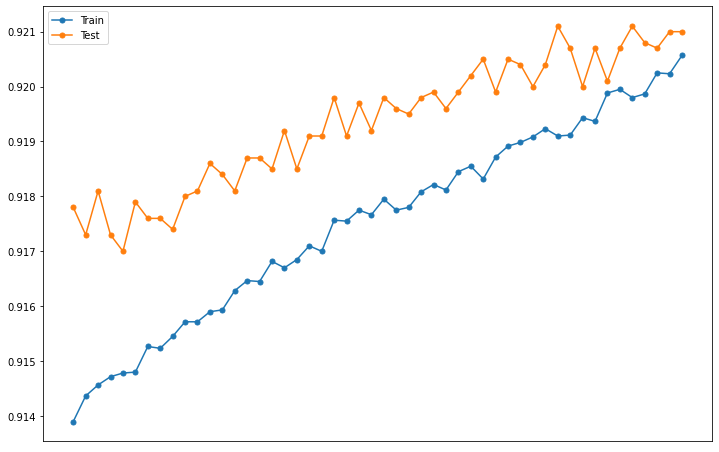

In [0]:
plotAccuracy(history0_df.accuracy, history0_df.val_accuracy)

In [0]:
predictions_train = model0.predict_classes(X_train, verbose=0)

In [0]:
confusion_matrix(t_train, predictions_train)

array([[5731,    1,   22,   12,   12,   40,   43,    7,   51,    4],
       [   1, 6548,   27,   26,    6,   32,    8,   16,   68,   10],
       [  36,   63, 5328,   85,   91,   24,   79,   84,  139,   29],
       [  20,   32,  127, 5484,    5,  202,   30,   64,  110,   57],
       [  12,   33,   36,    6, 5442,    2,   63,   13,   34,  201],
       [  74,   35,   46,  191,   63, 4690,   99,   23,  140,   60],
       [  35,   18,   47,    2,   48,   66, 5662,    5,   35,    0],
       [  26,   41,   80,   22,   52,    9,    3, 5821,   14,  197],
       [  31,  127,   71,  143,   26,  130,   50,   16, 5178,   79],
       [  32,   32,   22,   85,  173,   34,    3,  170,   48, 5350]])

In [0]:
accuracy_score(t_train, predictions_train)

0.9205666666666666

In [0]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Training set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Training set
Class 0: precision= 0.97, recall= 0.96, f-measure= 0.96
Class 1: precision= 0.97, recall= 0.96, f-measure= 0.96
Class 2: precision= 0.89, recall= 0.91, f-measure= 0.91
Class 3: precision= 0.89, recall= 0.90, f-measure= 0.90
Class 4: precision= 0.93, recall= 0.93, f-measure= 0.93
Class 5: precision= 0.87, recall= 0.88, f-measure= 0.88
Class 6: precision= 0.96, recall= 0.95, f-measure= 0.95
Class 7: precision= 0.93, recall= 0.93, f-measure= 0.93
Class 8: precision= 0.88, recall= 0.89, f-measure= 0.89
Class 9: precision= 0.90, recall= 0.90, f-measure= 0.90


In [0]:
predictions_test = model0.predict_classes(X_test, verbose=0)

In [0]:
confusion_matrix(t_test, predictions_test)

array([[ 963,    0,    3,    1,    0,    3,    7,    1,    2,    0],
       [   0, 1107,    2,    2,    1,    2,    4,    2,   15,    0],
       [   7,    8,  919,   15,   11,    2,   14,   13,   36,    7],
       [   3,    1,   24,  919,    0,   25,    2,   11,   17,    8],
       [   1,    1,    4,    1,  914,    0,   12,    2,    9,   38],
       [  10,    3,    3,   38,    9,  765,   18,    7,   31,    8],
       [  11,    3,    5,    2,    9,   13,  913,    1,    1,    0],
       [   2,   11,   22,    9,    6,    1,    0,  941,    2,   34],
       [   7,    7,    5,   24,    9,   25,   11,   11,  869,    6],
       [  12,    8,    2,   11,   39,    5,    0,   25,    7,  900]])

In [0]:
accuracy_score(t_test, predictions_test)

0.921

In [0]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.98, recall= 0.96, f-measure= 0.96
Class 1: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 2: precision= 0.89, recall= 0.91, f-measure= 0.91
Class 3: precision= 0.91, recall= 0.90, f-measure= 0.90
Class 4: precision= 0.93, recall= 0.92, f-measure= 0.92
Class 5: precision= 0.86, recall= 0.88, f-measure= 0.88
Class 6: precision= 0.95, recall= 0.94, f-measure= 0.94
Class 7: precision= 0.92, recall= 0.92, f-measure= 0.92
Class 8: precision= 0.89, recall= 0.89, f-measure= 0.89
Class 9: precision= 0.89, recall= 0.90, f-measure= 0.90


In [0]:
w0 = model0.layers[0].get_weights()
w = w0[0]

In [0]:
w0[1]

array([-0.35298458,  0.34349203,  0.09372354, -0.26865578,  0.0353708 ,
        1.1982946 , -0.0722384 ,  0.6038473 , -1.3471712 , -0.23369017],
      dtype=float32)

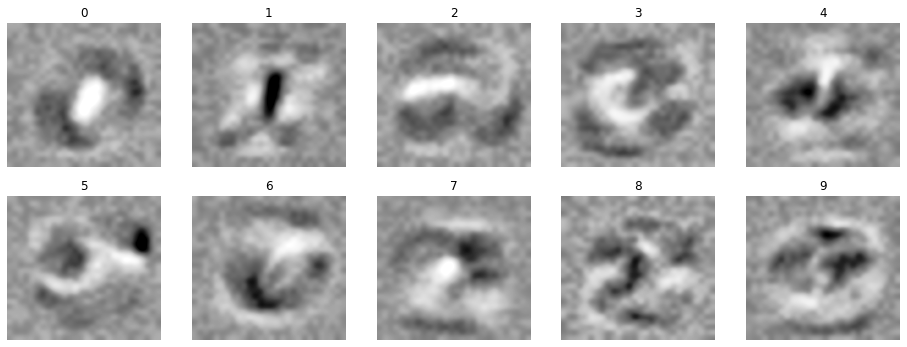

In [0]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

Elemento 7917


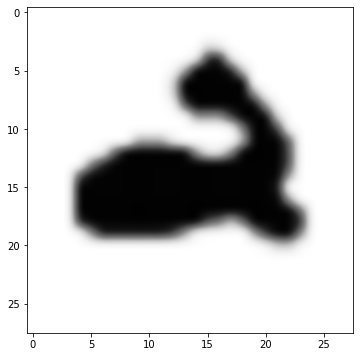

Un 2, classificato come 4


In [0]:
c = np.random.randint(0, X_test.shape[0])
p=model0.predict_classes(X_test[c:c+1,:], verbose=0)
print("Elemento "+str(c))
plotData(X_test, t_test, c)
print("Un "+str(t_test[c])+", classificato come " + str(p[0]))

In [0]:
# 3 layer NN
model1 = Sequential()
model1.add(Dense(512, input_shape=(784,)))
model1.add(Activation('relu'))
model1.add(Dropout(rate=0.2))
model1.add(Dense(10))
model1.add(Activation('softmax'))
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [0]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [0]:
#model1 = load_model_weights('nn3', model1)

In [0]:
history1 = model1.fit(X_train, T_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 50us/step - loss: 0.5838 - accuracy: 0.8402 - val_loss: 0.2569 - val_accuracy: 0.9255
Epoch 2/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.2396 - accuracy: 0.9313 - val_loss: 0.1899 - val_accuracy: 0.9447
Epoch 3/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.1817 - accuracy: 0.9485 - val_loss: 0.1513 - val_accuracy: 0.9558
Epoch 4/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.1454 - accuracy: 0.9587 - val_loss: 0.1284 - val_accuracy: 0.9628
Epoch 5/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.1229 - accuracy: 0.9653 - val_loss: 0.1127 - val_accuracy: 0.9665
Epoch 6/10
60000/60000 [==============================] - 3s 46us/step - loss: 0.1059 - accuracy: 0.9703 - val_loss: 0.1007 - val_accuracy: 0.9710
Epoch 7/10
60000/60000 [==============================] - 3s 47us/st

In [0]:
save_model(model1,'nn3')

Saved model to disk


In [0]:
history1_df = pd.DataFrame(history1.history)

In [0]:
history1_df.head()

,val_loss,val_accuracy,loss,accuracy
0,0.256934,0.9255,0.583778,0.840200
1,0.189939,0.9447,0.239606,0.931317
2,0.151271,0.9558,0.181706,0.948533
3,0.128383,0.9628,0.145432,0.958683
4,0.112664,0.9665,0.122881,0.965333


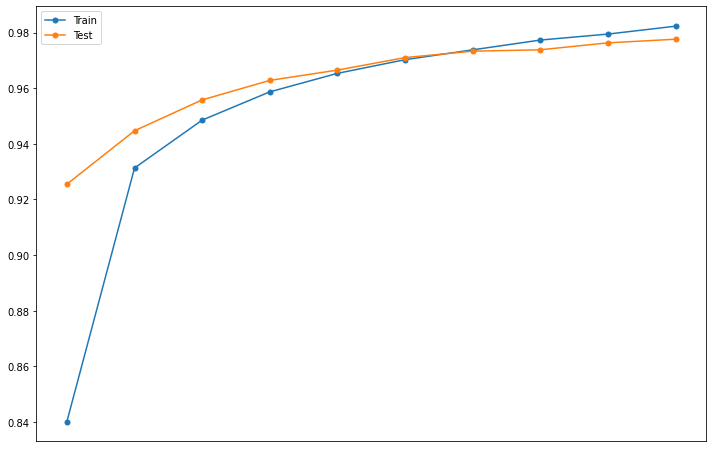

In [0]:
plotAccuracy(history1_df.accuracy, history1_df.val_accuracy)

In [0]:
predictions_train = model1.predict_classes(X_train, verbose=0)

In [0]:
confusion_matrix(t_train, predictions_train)

array([[5887,    2,    7,    1,    1,    1,   10,    1,    8,    5],
       [   1, 6702,   13,    2,    8,    0,    2,    8,    5,    1],
       [   5,   10, 5907,    6,    7,    1,    0,   14,    5,    3],
       [   2,    5,   24, 6029,    1,   20,    0,   15,   18,   17],
       [   3,   12,    4,    1, 5781,    1,    5,    4,    2,   29],
       [   7,    5,    3,   24,    5, 5346,   11,    1,    9,   10],
       [  11,    9,    1,    0,    7,   16, 5866,    0,    8,    0],
       [   2,   17,   18,    1,   10,    1,    0, 6199,    2,   15],
       [  14,   34,   16,   21,    4,   11,    9,    4, 5725,   13],
       [   9,   11,    1,   19,   30,   11,    1,   26,    9, 5832]])

In [0]:
accuracy_score(t_train, predictions_train)

0.9879

In [0]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Training set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Training set
Class 0: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 1: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 3: precision= 0.98, recall= 0.99, f-measure= 0.99
Class 4: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 5: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 6: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 7: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 8: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 9: precision= 0.98, recall= 0.98, f-measure= 0.98


In [0]:
predictions_test = model1.predict_classes(X_test, verbose=0)

In [0]:
confusion_matrix(t_test, predictions_test)

array([[ 971,    0,    2,    1,    1,    2,    1,    1,    1,    0],
       [   0, 1126,    2,    1,    0,    1,    2,    0,    3,    0],
       [   4,    2, 1009,    2,    1,    0,    2,    5,    6,    1],
       [   0,    0,    2,  994,    0,    4,    0,    4,    4,    2],
       [   0,    0,    4,    1,  962,    0,    3,    2,    2,    8],
       [   2,    0,    0,    6,    2,  871,    4,    0,    5,    2],
       [   5,    3,    2,    1,    6,    5,  933,    0,    3,    0],
       [   0,    5,   11,    3,    0,    1,    0, 1002,    0,    6],
       [   3,    1,    5,   10,    4,    4,    1,    3,  939,    4],
       [   3,    6,    1,   10,    9,    3,    1,    6,    1,  969]])

In [0]:
accuracy_score(t_test, predictions_test)

0.9776

In [0]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 1: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 3: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 4: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 5: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 6: precision= 0.97, recall= 0.98, f-measure= 0.98
Class 7: precision= 0.97, recall= 0.98, f-measure= 0.98
Class 8: precision= 0.96, recall= 0.97, f-measure= 0.97
Class 9: precision= 0.96, recall= 0.97, f-measure= 0.97


In [0]:
# 4 layer NN
model2 = Sequential()
model2.add(Dense(512, input_shape=(784,)))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10))
model2.add(Activation('softmax'))

In [0]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [0]:
model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [0]:
#model2 = load_model_weights('nn4', model2)

In [0]:
history2 = model2.fit(X_train, T_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.5063 - accuracy: 0.8563 - val_loss: 0.1870 - val_accuracy: 0.9435
Epoch 2/10
60000/60000 [==============================] - 5s 84us/step - loss: 0.1752 - accuracy: 0.9492 - val_loss: 0.1212 - val_accuracy: 0.9627
Epoch 3/10
60000/60000 [==============================] - 5s 84us/step - loss: 0.1217 - accuracy: 0.9638 - val_loss: 0.1025 - val_accuracy: 0.9677
Epoch 4/10
60000/60000 [==============================] - 5s 85us/step - loss: 0.0933 - accuracy: 0.9722 - val_loss: 0.0808 - val_accuracy: 0.9747
Epoch 5/10
60000/60000 [==============================] - 5s 85us/step - loss: 0.0746 - accuracy: 0.9779 - val_loss: 0.0720 - val_accuracy: 0.9770
Epoch 6/10
60000/60000 [==============================] - 5s 85us/step - loss: 0.0579 - accuracy: 0.9824 - val_loss: 0.0654 - val_accuracy: 0.9791
Epoch 7/10
60000/60000 [==============================] - 5s 86us/st

In [0]:
save_model(model2,'nn4')

Saved model to disk


In [0]:
history2_df = pd.DataFrame(history2.history)

In [0]:
history2_df.head()

,val_loss,val_accuracy,loss,accuracy
0,0.187013,0.9435,0.506344,0.856283
1,0.121152,0.9627,0.175229,0.949183
2,0.102464,0.9677,0.121734,0.963783
3,0.080770,0.9747,0.093332,0.972183
4,0.071972,0.9770,0.074594,0.977917


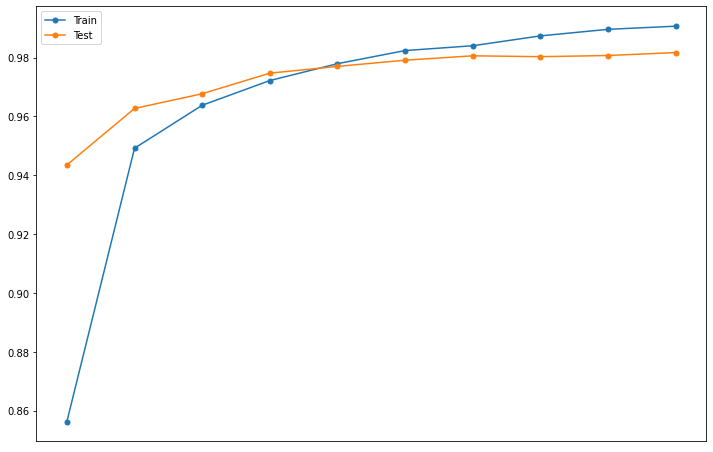

In [0]:
plotAccuracy(history2_df.accuracy, history2_df.val_accuracy)

In [0]:
predictions_train = model2.predict_classes(X_train, verbose=0)

In [0]:
confusion_matrix(t_train, predictions_train)

array([[5918,    0,    1,    0,    0,    0,    1,    0,    3,    0],
       [   0, 6730,    2,    1,    2,    1,    0,    2,    3,    1],
       [   2,    1, 5942,    6,    0,    0,    1,    4,    2,    0],
       [   0,    0,    4, 6106,    0,    9,    0,    1,    8,    3],
       [   0,    1,    0,    0, 5833,    0,    1,    1,    1,    5],
       [   0,    1,    0,    5,    0, 5411,    1,    0,    2,    1],
       [   9,    3,    0,    0,    2,    2, 5899,    0,    3,    0],
       [   0,    6,    5,    0,    2,    0,    0, 6246,    0,    6],
       [   2,    6,    0,    5,    0,    6,    3,    1, 5825,    3],
       [   4,    2,    0,    3,   12,    3,    0,    3,    9, 5913]])

In [0]:
accuracy_score(t_train, predictions_train)

0.99705

In [0]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Training set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Training set
Class 0: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 1: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 2: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 3: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 4: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 5: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 6: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 7: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 8: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 9: precision= 0.99, recall= 1.00, f-measure= 1.00


In [0]:
predictions_test = model2.predict_classes(X_test, verbose=0)

In [0]:
confusion_matrix(t_test, predictions_test)

array([[ 971,    1,    1,    0,    1,    2,    1,    1,    2,    0],
       [   0, 1126,    3,    1,    0,    1,    2,    0,    2,    0],
       [   2,    0, 1015,    4,    1,    0,    1,    4,    4,    1],
       [   0,    0,    3,  996,    0,    3,    0,    3,    3,    2],
       [   0,    0,    4,    0,  966,    0,    3,    2,    0,    7],
       [   2,    0,    0,    7,    1,  874,    2,    1,    3,    2],
       [   6,    3,    2,    1,    4,    5,  934,    0,    3,    0],
       [   0,    5,    8,    2,    1,    0,    0, 1003,    3,    6],
       [   2,    0,    2,    4,    2,    4,    1,    2,  954,    3],
       [   2,    2,    0,    7,    9,    3,    2,    4,    2,  978]])

In [0]:
accuracy_score(t_test, predictions_test)

0.9817

In [0]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 1: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 3: precision= 0.99, recall= 0.98, f-measure= 0.98
Class 4: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 5: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 6: precision= 0.97, recall= 0.98, f-measure= 0.98
Class 7: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 8: precision= 0.98, recall= 0.98, f-measure= 0.98
Class 9: precision= 0.97, recall= 0.97, f-measure= 0.97


In [0]:
model3 = Sequential()
model3.add(Conv2D(30, (5, 5), input_shape=(28, 28,1), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(15, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(50, activation='relu'))
model3.add(Dense(10, activation='softmax'))

In [0]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

In [0]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
X_train_c = X_train.reshape(X_train.shape[0], 28, 28,1).astype('float32')
X_test_c = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

In [0]:
#model3 = load_model_weights('cnn', model3)

In [0]:
history3 = model3.fit(X_train_c, T_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test_c, T_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 33s 556us/step - loss: 1.0933 - accuracy: 0.6511 - val_loss: 0.2442 - val_accuracy: 0.9319
Epoch 2/10
60000/60000 [==============================] - 33s 547us/step - loss: 0.2142 - accuracy: 0.9366 - val_loss: 0.1038 - val_accuracy: 0.9687
Epoch 3/10
60000/60000 [==============================] - 33s 553us/step - loss: 0.1253 - accuracy: 0.9624 - val_loss: 0.0693 - val_accuracy: 0.9782
Epoch 4/10
60000/60000 [==============================] - 33s 545us/step - loss: 0.0976 - accuracy: 0.9699 - val_loss: 0.0532 - val_accuracy: 0.9830
Epoch 5/10
60000/60000 [==============================] - 33s 545us/step - loss: 0.0831 - accuracy: 0.9745 - val_loss: 0.0469 - val_accuracy: 0.9857
Epoch 6/10
60000/60000 [==============================] - 33s 545us/step - loss: 0.0705 - accuracy: 0.9783 - val_loss: 0.0437 - val_accuracy: 0.9852
Epoch 7/10
60000/60000 [==============================] 

In [0]:
save_model(model3,'cnn')

Saved model to disk


In [0]:
history3_df = pd.DataFrame(history3.history) 

In [0]:
history3_df.head()

,val_loss,val_accuracy,loss,accuracy
0,0.244188,0.9319,1.093259,0.651083
1,0.103793,0.9687,0.214250,0.936600
2,0.069310,0.9782,0.125295,0.962350
3,0.053211,0.9830,0.097571,0.969900
4,0.046882,0.9857,0.083100,0.974467


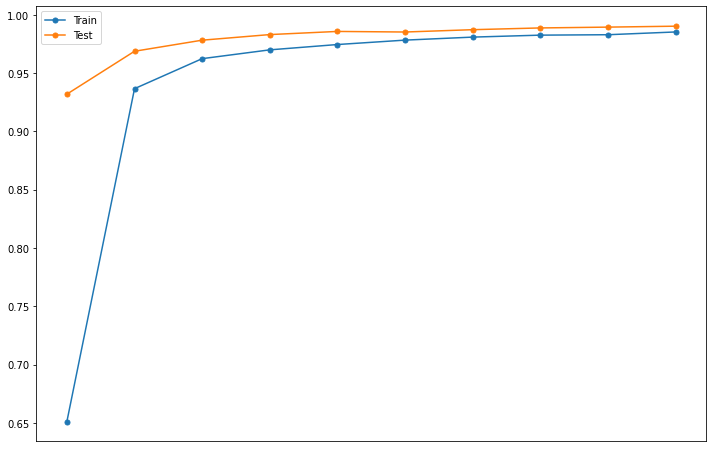

In [0]:
plotAccuracy(history3_df.accuracy, history3_df.val_accuracy)

In [0]:
predictions_train = model3.predict_classes(X_train_c, verbose=0)

In [0]:
confusion_matrix(t_train, predictions_train)

array([[5902,    0,    3,    1,    1,    0,    6,    1,    5,    4],
       [   1, 6700,    7,    3,    2,    0,    4,   12,    9,    4],
       [   1,    4, 5917,   10,    5,    0,    1,    8,    9,    3],
       [   1,    0,   16, 6071,    0,   15,    0,    9,   10,    9],
       [   1,    2,    5,    0, 5800,    0,    4,    4,    5,   21],
       [   3,    1,    2,   20,    0, 5364,   11,    0,   14,    6],
       [   9,    2,    3,    1,    4,    4, 5882,    0,   13,    0],
       [   0,    9,   21,    7,   10,    2,    0, 6190,   10,   16],
       [   7,    5,   10,    7,    4,   11,    6,    1, 5786,   14],
       [   9,    3,    0,    8,   20,   13,    0,   17,   15, 5864]])

In [0]:
accuracy_score(t_train, predictions_train)

0.9912666666666666

In [0]:
meas = precision_recall_fscore_support(t_train, predictions_train, average=None)
print('Training set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Training set
Class 0: precision= 1.00, recall= 1.00, f-measure= 1.00
Class 1: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 3: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 4: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 5: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 6: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 7: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 8: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 9: precision= 0.99, recall= 0.99, f-measure= 0.99


In [0]:
predictions_test = model3.predict_classes(X_test_c, verbose=0)

In [0]:
confusion_matrix(t_test, predictions_test)

array([[ 977,    0,    0,    0,    0,    0,    1,    1,    1,    0],
       [   0, 1128,    2,    0,    2,    0,    1,    0,    2,    0],
       [   1,    1, 1026,    1,    1,    0,    0,    2,    0,    0],
       [   0,    0,    1, 1005,    0,    1,    0,    2,    1,    0],
       [   0,    0,    1,    0,  975,    0,    0,    0,    2,    4],
       [   1,    0,    0,    4,    0,  886,    1,    0,    0,    0],
       [   6,    2,    1,    1,    1,    4,  941,    0,    2,    0],
       [   1,    3,    5,    2,    0,    0,    0, 1012,    1,    4],
       [   3,    0,    1,    1,    0,    0,    2,    1,  963,    3],
       [   2,    3,    1,    0,    5,    2,    0,    4,    3,  989]])

In [0]:
accuracy_score(t_test, predictions_test)

0.9902

In [0]:
meas = precision_recall_fscore_support(t_test, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 1.00, recall= 0.99, f-measure= 0.99
Class 1: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 2: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 3: precision= 1.00, recall= 0.99, f-measure= 0.99
Class 4: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 5: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 6: precision= 0.98, recall= 0.99, f-measure= 0.99
Class 7: precision= 0.98, recall= 0.99, f-measure= 0.99
Class 8: precision= 0.99, recall= 0.99, f-measure= 0.99
Class 9: precision= 0.98, recall= 0.98, f-measure= 0.98
